# Persistence Diagram Covariance Analysis

This notebook performs a covariance analysis for a time series of persistence diagrams. The persistence plane is partitioned into various regions, each of which is served to provide a random variable given by the count of the number of persistence points in that region. The time series of counts are then run through a covariance analysis to determine the covariance decay with respect to the lag.

In [12]:
import numpy as np
import scipy
import pandas as pd
from scipy import misc
from matplotlib import pyplot as plt
import math, time
import seaborn.apionly as sns 

import sys

%matplotlib inline  

## User-defined variables

In [13]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast/g21flow/'
sPD_pattern = 'pd_sublevel/%05d__sub_all.csv'
data_range = range(1,1500 + 1) # Images to loop through
region_range = range(25, 150) # Regions on the persistence plane to loop through
covariance_windows = range(1, 500 + 1) # Windows for computing covariance decays
noise_level = 50 # Minimum death time for persistence points
max_level = 235 # The value to consider to be the "top" of the persistence plane, on average
dim = 0

## Load the data

In [14]:
region_counts = np.zeros((len(region_range), len(data_range), 4))

for i in data_range:
    data = pd.read_csv(sDir+(sPD_pattern % i))
    data = data.loc[data['dim']==dim]
    for region in region_range:
        region_key_x = region
        region_key_y = max_level - region

        top_left = len(data.loc[(data['birth'] <= region_key_x) & (data['death'] >= region_key_y) ])
        top = len(data.loc[(data['birth'] > region_key_x) & (data['death'] >= region_key_y) ])
        left = len(data.loc[(data['birth'] <= region_key_x) & (data['death'] < region_key_y) & (data['death'] >= noise_level) ])
        center = len(data.loc[(data['birth'] > region_key_x) & (data['death'] < region_key_y) & (data['death'] >= noise_level) ])
        
        region_counts[region-min(region_range), i-min(data_range)] = [top_left, top, left, center]

## Compute the covariances

In [15]:
covariances = np.zeros((len(covariance_windows), len(region_range), 4))

for window in covariance_windows:
    base_counts = region_counts[:, 0:(len(data_range) - window), :]
    base_counts_normalized = (base_counts - np.mean(base_counts))
    base_counts_normalized = base_counts
    shifted_counts = region_counts[:, window:len(data_range), :]
    shifted_counts_normalized = (shifted_counts - np.mean(shifted_counts))
    shifted_counts_normalized = shifted_counts
    for region_idx in range(0,len(region_range)):
        for i in range(0,4):
            covariances[(window - min(covariance_windows)), region_idx, i] = np.cov(np.vstack((base_counts_normalized[region_idx, :, i], shifted_counts_normalized[region_idx, :, i])))[0,1]

## Plot the time series data

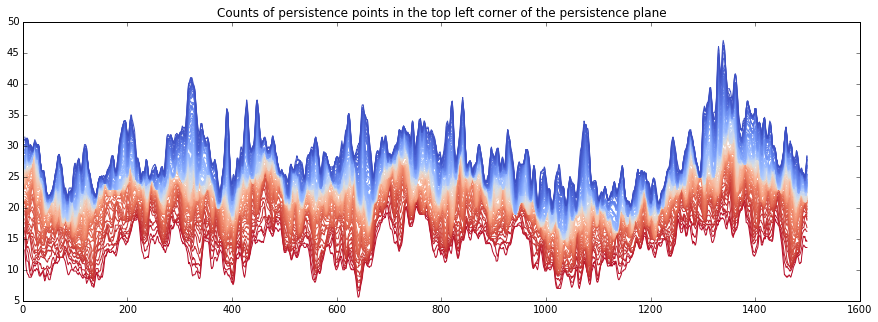

In [16]:

num_lines = len(region_range)

plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_color_cycle(sns.color_palette("coolwarm_r",num_lines))

plt.title('Counts of persistence points in the top left corner of the persistence plane')
for i in range(0,num_lines):
    plt.plot(pd.rolling_mean(pd.DataFrame(region_counts[i,:,0]),5))

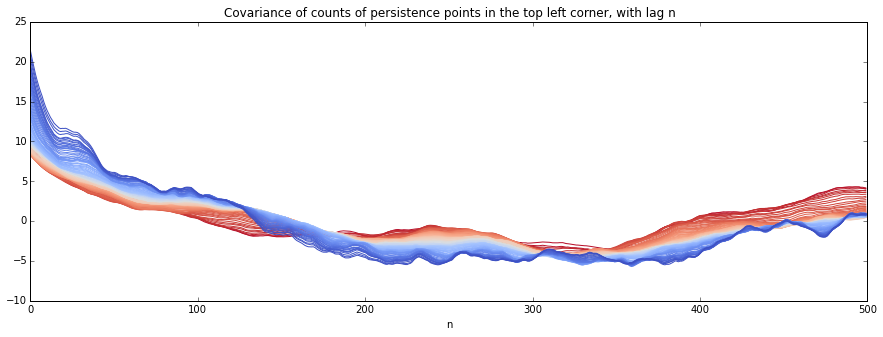

In [17]:

plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_color_cycle(sns.color_palette("coolwarm_r",num_lines))

plt.title('Covariance of counts of persistence points in the top left corner, with lag n')
plt.xlabel('n')
for i in range(0,num_lines):
    plt.plot(covariances[:,i,0])